In [85]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [34]:
# USING TORCH --> NEED DEVICE 
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [35]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # required preprocessing of image data
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # first fully connected layer, maps input (28*28 pixels = 784 pixels) to 512 hidden units
            nn.ReLU(), # activation function
            nn.Linear(512, 512), # second fully connected layer, maps 512 hidden units to 512 hidden units
            nn.ReLU(), # activation function
            nn.Linear(512, 10), # third fully connected layer, maps 512 hidden units to 10 output units
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
# MOVE MODEL TO DEVICE
model = NeuralNetwork().to(device)

In [58]:
class CIFARNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # required preprocessing of image data
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 512), # first fully connected layer, maps input (28*28 pixels = 784 pixels) to 512 hidden units
            nn.ReLU(), # activation function
            nn.Linear(512, 512), # second fully connected layer, maps 512 hidden units to 512 hidden units
            nn.ReLU(), # activation function
            nn.Linear(512, 10), # third fully connected layer, maps 512 hidden units to 10 output units
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
# MOVE MODEL TO DEVICE
model = CIFARNeuralNetwork().to(device)

In [ ]:
class BetterCIFAR10Network(nn.Module):
    def __init__(self):
        super(BetterCIFAR10Network, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # 128 feature maps of size 4x4 after pooling
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 output classes for CIFAR-10

        # Pooling layer and dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # CONVOULUTIONAL LAYERS FIRST
        # Pass through conv layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 8x8 -> 4x4
        
        # FLATTEN IMAGE FOR FULLY CONNECTED LAYERS
        x = x.view(-1, 128 * 4 * 4)
        
        # NOW FULLY CONNECTED LAYERS
        # Pass through fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        
        # USE LAST FULLY CONNECTED LAYER WITHOUT ACTIVATION FUNCTION
        # Output layer
        x = self.fc3(x)
    
        return x
        
# MOVE MODEL TO DEVICE
model = BetterCIFAR10Network().to(device)

In [89]:
# Define any necessary transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# CHOOSE DATASET
# MNIST (1x28x28)
# train_dataset = datasets.MNIST(root="data", train=True, transform=transform, download=True) # train dataset MNIST
# test_dataset = datasets.MNIST(root="data", train=False, transform=transform, download=True) # validation dataset MNIST

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor() # can add functionality for more transformation / pre-procressing options
]))

# # FashionMNIST (1x28x28) batch size = 64
#train_dataset = datasets.FashionMNIST(root="data", train=True, transform=transform, download=True) # train dataloader
#test_dataset = datasets.FashionMNIST(root="data", train=False, transform=transform, download=True) # validation dataloader

# # CIFAR-10  (3x32x32) batxh size = 64
train_dataset = datasets.CIFAR10(root="data", train=True, transform=transform, download=True) # train dataloader
test_dataset = datasets.CIFAR10(root="data", train=False, transform=transform, download=True) # validation dataloader


Files already downloaded and verified
Files already downloaded and verified


In [90]:
# PICK BATCH SIZE. USE DATALOADER TO CREATE BATCHES
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [91]:
# CHOOSE LOSS FUNCTION
# CHOOSE OPTIMIZER FUNCTION
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3) # LATER --> CH0OSE LEARING RATE

In [95]:
# training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    # Average loss over all batches
    avg_train_loss = train_loss / len(dataloader)
    return avg_train_loss

In [96]:
# testing function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) # put X and y on (GPU) device; model is already on (GPU) device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    # Average loss over all batches
    avg_test_loss = test_loss
    return avg_test_loss

In [106]:
# Graphing metrics

# Initialize lists to store the losses
train_losses = []
test_losses = []

# SPECIFIY NUMBER OF EPOCHS
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss = train(train_loader, model, loss_fn, optimizer)
    avg_test_loss = test(test_loader, model, loss_fn)

    # Store losses
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

print("Done!")

Epoch 1
-------------------------------
loss: 2.293687  [   32/50000]
loss: 2.262197  [ 3232/50000]
loss: 2.259652  [ 6432/50000]
loss: 2.269625  [ 9632/50000]
loss: 2.263237  [12832/50000]
loss: 2.264805  [16032/50000]
loss: 2.255563  [19232/50000]
loss: 2.291187  [22432/50000]
loss: 2.255478  [25632/50000]
loss: 2.238580  [28832/50000]
loss: 2.292562  [32032/50000]
loss: 2.267987  [35232/50000]
loss: 2.244524  [38432/50000]
loss: 2.304116  [41632/50000]
loss: 2.260652  [44832/50000]
loss: 2.255134  [48032/50000]
Test Error: 
 Accuracy: 17.3%, Avg loss: 2.249598 

Epoch 2
-------------------------------
loss: 2.275083  [   32/50000]
loss: 2.277533  [ 3232/50000]
loss: 2.258524  [ 6432/50000]
loss: 2.223110  [ 9632/50000]
loss: 2.258765  [12832/50000]
loss: 2.190108  [16032/50000]
loss: 2.275903  [19232/50000]
loss: 2.182076  [22432/50000]
loss: 2.216723  [25632/50000]
loss: 2.261902  [28832/50000]
loss: 2.248464  [32032/50000]
loss: 2.235456  [35232/50000]
loss: 2.181158  [38432/50000

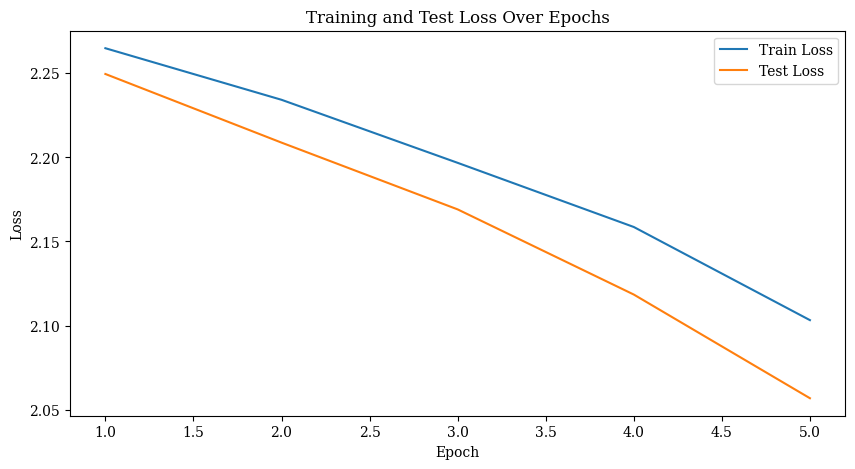

In [107]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.show()

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.show()

In [87]:
# # Epoch Log / Training / Testing
# epochs = 5
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_loader, model, loss_fn, optimizer)
#     test(test_loader, model, loss_fn)
# print("Done!")

Epoch 1
-------------------------------
loss: 2.291472  [   32/50000]
loss: 2.322479  [ 3232/50000]
loss: 2.309046  [ 6432/50000]
loss: 2.293512  [ 9632/50000]
loss: 2.286935  [12832/50000]
loss: 2.288884  [16032/50000]
loss: 2.310317  [19232/50000]
loss: 2.294317  [22432/50000]
loss: 2.295004  [25632/50000]
loss: 2.310099  [28832/50000]
loss: 2.300539  [32032/50000]
loss: 2.304547  [35232/50000]
loss: 2.311769  [38432/50000]
loss: 2.308161  [41632/50000]
loss: 2.314659  [44832/50000]
loss: 2.305649  [48032/50000]
Test Error: 
 Accuracy: 11.5%, Avg loss: 2.303856 

Epoch 2
-------------------------------
loss: 2.317610  [   32/50000]
loss: 2.291832  [ 3232/50000]
loss: 2.299459  [ 6432/50000]
loss: 2.298040  [ 9632/50000]
loss: 2.291377  [12832/50000]
loss: 2.299162  [16032/50000]
loss: 2.299660  [19232/50000]
loss: 2.286504  [22432/50000]
loss: 2.310963  [25632/50000]
loss: 2.320834  [28832/50000]
loss: 2.312184  [32032/50000]
loss: 2.299820  [35232/50000]
loss: 2.287823  [38432/50000